In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [6]:
url = 'https://github.com/sehyunlee217/MIE368_proj/blob/main/watson_healthcare_modified.csv?raw=true'

In [136]:
# reading df from github repo
df = pd.read_csv(url)

In [137]:
df.head()

,EmployeeID,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,...,RelationshipSatisfaction,StandardHours,Shift,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1313919,41,No,Travel_Rarely,1102,Cardiology,1,2,Life Sciences,1,...,1,80,0,8,0,1,6,4,0,5
1,1200302,49,No,Travel_Frequently,279,Maternity,8,1,Life Sciences,1,...,4,80,1,10,3,3,10,7,1,7
2,1060315,37,Yes,Travel_Rarely,1373,Maternity,2,2,Other,1,...,2,80,0,7,3,3,0,0,0,0
3,1272912,33,No,Travel_Frequently,1392,Maternity,3,4,Life Sciences,1,...,3,80,0,8,3,3,8,7,3,0
4,1414939,27,No,Travel_Rarely,591,Maternity,2,1,Medical,1,...,4,80,1,6,3,3,2,2,2,2


In [138]:
df.drop(columns=['EmployeeID', 'EmployeeCount','Shift', 'StandardHours','Over18'], inplace=True)

In [139]:
# training set 
y = df['Attrition']
X = df.drop(columns=['Attrition']) # test set
y = y.map({"Yes":1, "No":0})
df['Attrition'] = y

In [140]:
df['Attrition']

0       0
1       0
2       1
3       0
4       0
       ..
1671    1
1672    0
1673    0
1674    0
1675    0
Name: Attrition, Length: 1676, dtype: int64

In [141]:
# Select Dtype columns that are non-string(ints,floats,..)
num_columns = df.select_dtypes(exclude=['object']).columns
# Select string-type columns 
str_columns = [col for col in df.columns if col not in num_columns]

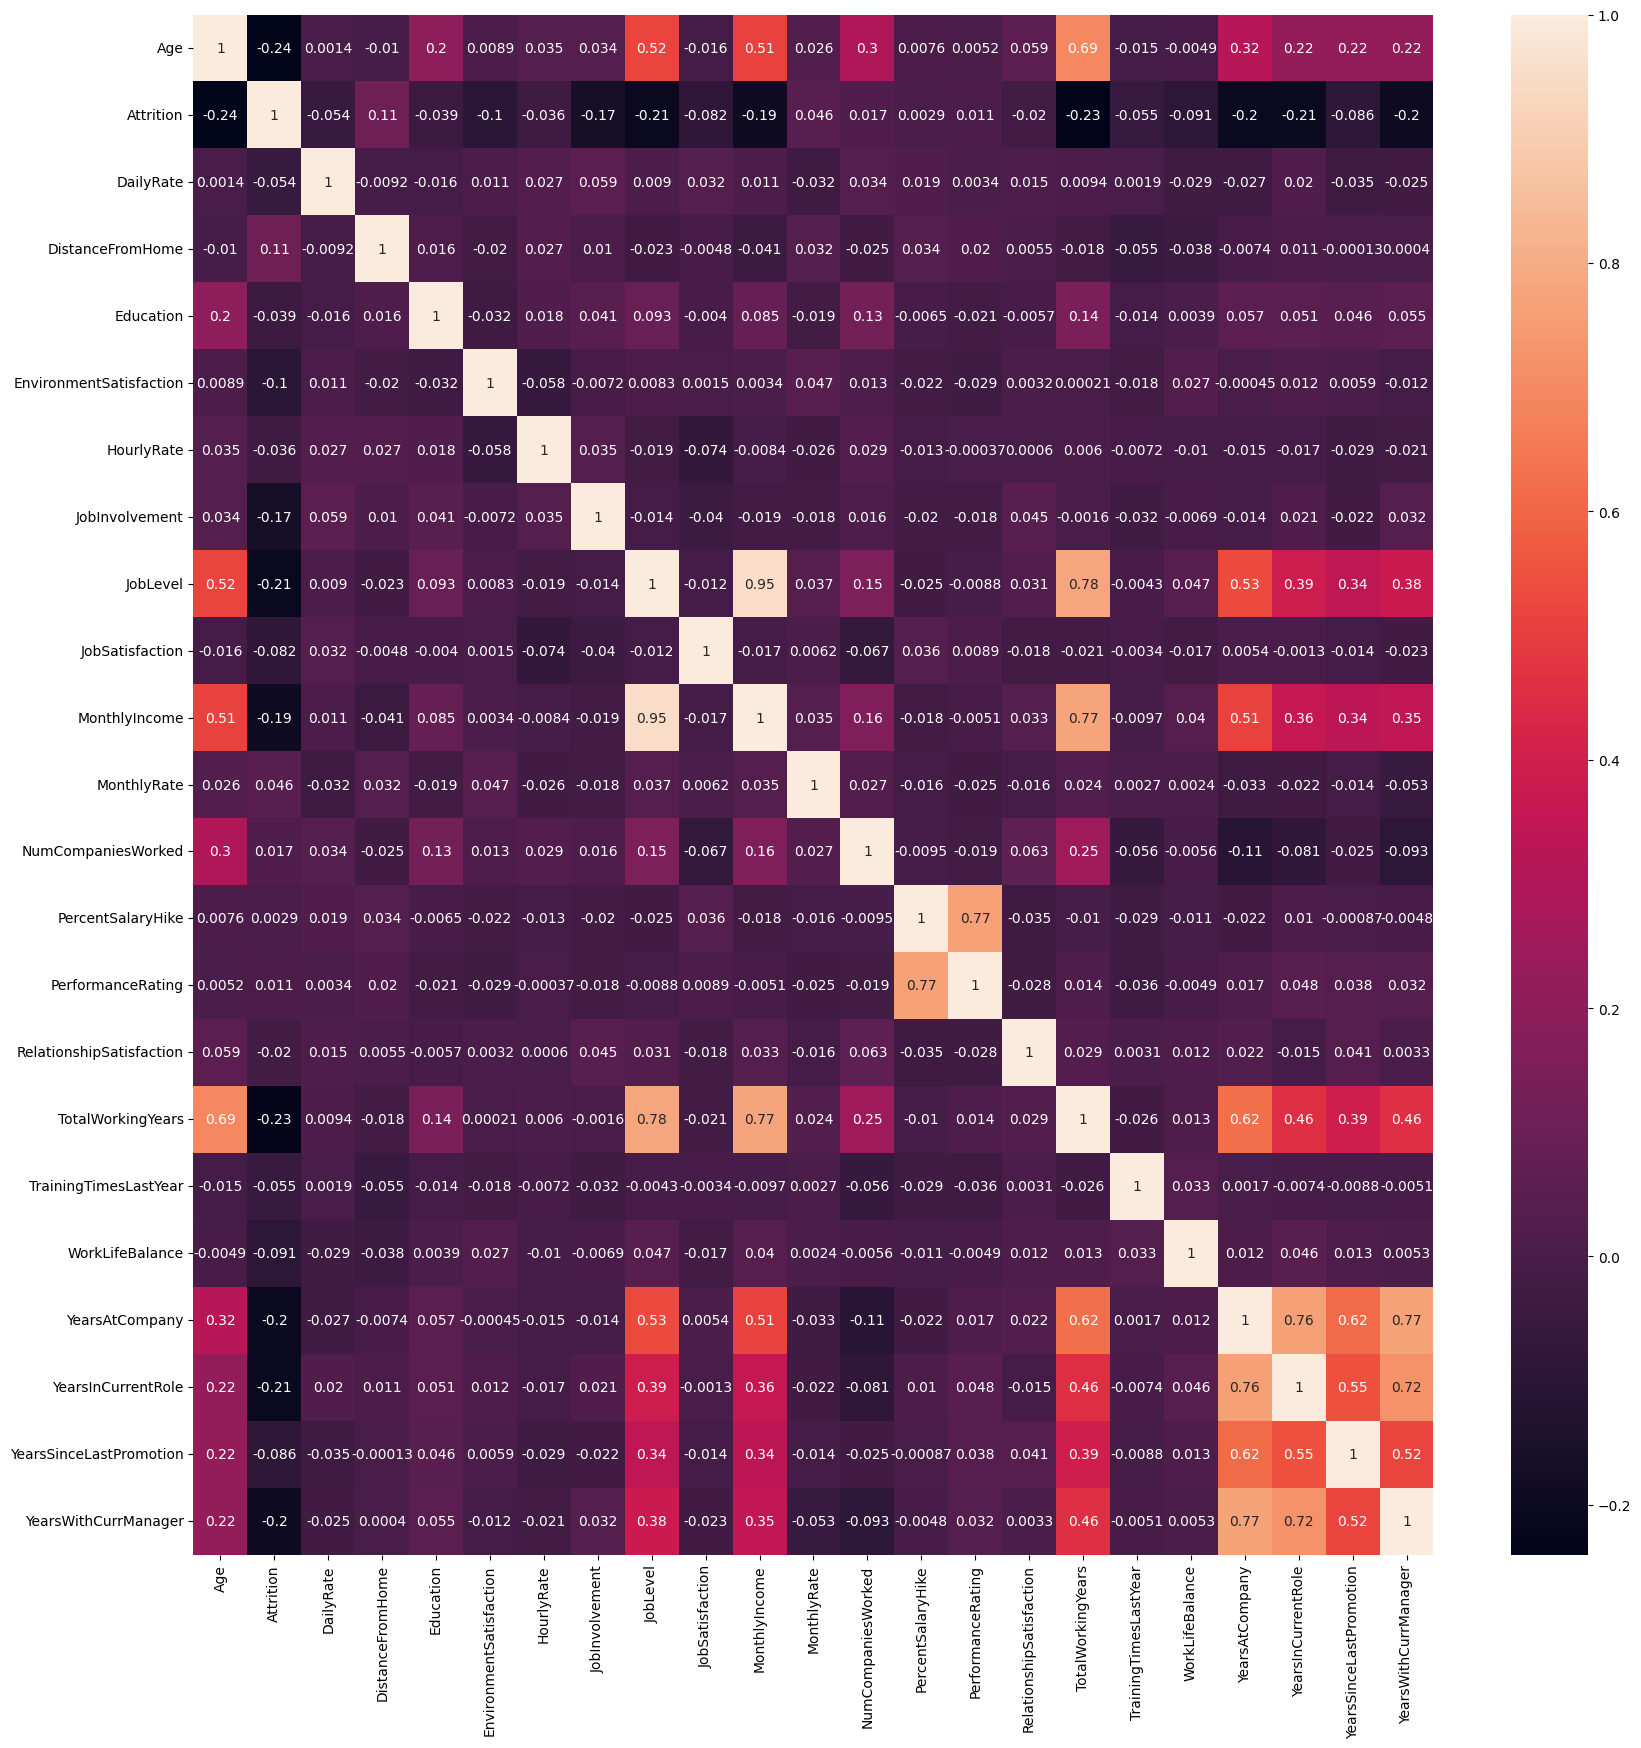

In [142]:
# Let's check correlation between numerical columns 
cor = df[num_columns].corr()
plt.figure(figsize=(20,20))
sns.heatmap(cor, annot=True)
plt.show()

In [143]:
# Get first 5 most correlated features 
cor['Attrition'].sort_values(ascending=True)[:5]

Age                  -0.239984
TotalWorkingYears    -0.234182
YearsInCurrentRole   -0.207891
JobLevel             -0.207634
YearsAtCompany       -0.201373
Name: Attrition, dtype: float64

In [144]:
# Let's check point biserial correlation between numerical v.s target
# Store p_values for each pair 
pv_dict = {}
alpha = 0.05

for col in num_columns:
    if stats.pointbiserialr(df[col], y).pvalue < alpha: 
        pv_dict[col] = stats.pointbiserialr(df[col], y).pvalue
    
pv_dict.pop('Attrition')
sorted(pv_dict.items(), key=lambda x: x[1])[:5]

[('Age', 2.2059860465151512e-23),
 ('TotalWorkingYears', 2.591849133080902e-22),
 ('YearsInCurrentRole', 8.070296619431751e-18),
 ('JobLevel', 8.870805904375037e-18),
 ('YearsAtCompany', 8.559210839950406e-17)]

### We seem to get consistent result from correlation and biserial correlation against Attrition

- So Age, TotalWorkignYears, YearsInCurrentRole, JobLevel, and YearsAtCompany seem to be potential counfounding factors.
- Now, let's encode the categorical features and check for significant features; Remember that correlation can only be calculated for continuous/numerical features. That's why we did these tests on numerical features first. 

In [145]:
# Columns that were not numerical
df[str_columns]

# Let's check how many categories these non-numerical features have
for col in str_columns:
    print(f"{col} | number of types: {len(df[col].unique())}")
    print(df[col].unique(), "\n")

# We want to check which of these are ordinal or nominal
# if ordinal, mapping to values workds
# if nominal, one-hot encoding

BusinessTravel | number of types: 3
['Travel_Rarely' 'Travel_Frequently' 'Non-Travel'] 

Department | number of types: 3
['Cardiology' 'Maternity' 'Neurology'] 

EducationField | number of types: 6
['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources'] 

Gender | number of types: 2
['Female' 'Male'] 

JobRole | number of types: 5
['Nurse' 'Other' 'Therapist' 'Administrative' 'Admin'] 

MaritalStatus | number of types: 3
['Single' 'Married' 'Divorced'] 

OverTime | number of types: 2
['Yes' 'No'] 



## now we can check the types of our features
Binary variables: Gender, Overtime 

Ordinal: BusinessTravel

Nominal: Department, EducationField, JobRole, MartialStatus

In [146]:
# first map binary and ordinal features to numerical 
df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
df['OverTime'] = df['OverTime'].map({'No': 0, 'Yes': 1})
df['BusinessTravel'] = df['BusinessTravel'].map(
    {'Non-Travel':0, 'Travel_Rarely':1, 'Travel_Frequently':2})

# Confirm we converted these variables
df[['Gender','OverTime','BusinessTravel']].head()

,Gender,OverTime,BusinessTravel
0,1,1,1
1,0,0,2
2,0,1,1
3,1,1,2
4,0,0,1


In [147]:
from sklearn import preprocessing as p

In [148]:
df[str_columns].head()

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,OverTime
0,1,Cardiology,Life Sciences,1,Nurse,Single,1
1,2,Maternity,Life Sciences,0,Other,Married,0
2,1,Maternity,Other,0,Nurse,Single,1
3,2,Maternity,Life Sciences,1,Other,Married,1
4,1,Maternity,Medical,0,Nurse,Married,0


In [149]:
# We only want to hot-encode nominal variables 
cols_nom = ['Department','EducationField','JobRole','MaritalStatus']

nom_df = df[cols_nom]

In [150]:
# Apply one-hot encoding to nominal variables
encoder = p.OneHotEncoder()

encoder.fit(nom_df)
onehotlables = encoder.transform(nom_df)

encoded_cols = pd.DataFrame(onehotlables.toarray(), columns=encoder.get_feature_names_out(), dtype=int)

In [151]:
encoded_cols.head()

,Department_Cardiology,Department_Maternity,Department_Neurology,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Admin,JobRole_Administrative,JobRole_Nurse,JobRole_Other,JobRole_Therapist,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
2,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1
3,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0
4,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0


In [173]:
# Now we merge the tables with the one-hot encoded features 
train_df = df
# Drop all string columns
train_df.drop(columns=cols_nom, inplace=True)
# Merge the encoded columns
train_df = train_df.join(encoded_cols)

In [174]:
print(df.shape)
print(train_df.shape)
train_df.head()

(1676, 26)
(1676, 43)


,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,...,EducationField_Other,EducationField_Technical Degree,JobRole_Admin,JobRole_Administrative,JobRole_Nurse,JobRole_Other,JobRole_Therapist,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
0,41,0,1,1102,1,2,2,1,94,3,...,0,0,0,0,1,0,0,0,0,1
1,49,0,2,279,8,1,3,0,61,2,...,0,0,0,0,0,1,0,0,1,0
2,37,1,1,1373,2,2,4,0,92,2,...,1,0,0,0,1,0,0,0,0,1
3,33,0,2,1392,3,4,4,1,56,3,...,0,0,0,0,0,1,0,0,1,0
4,27,0,1,591,2,1,1,0,40,3,...,0,0,0,0,1,0,0,0,1,0


We can see that we have 17 more features due to the encoding. But now we can reapply correlation and even do some PCA. 

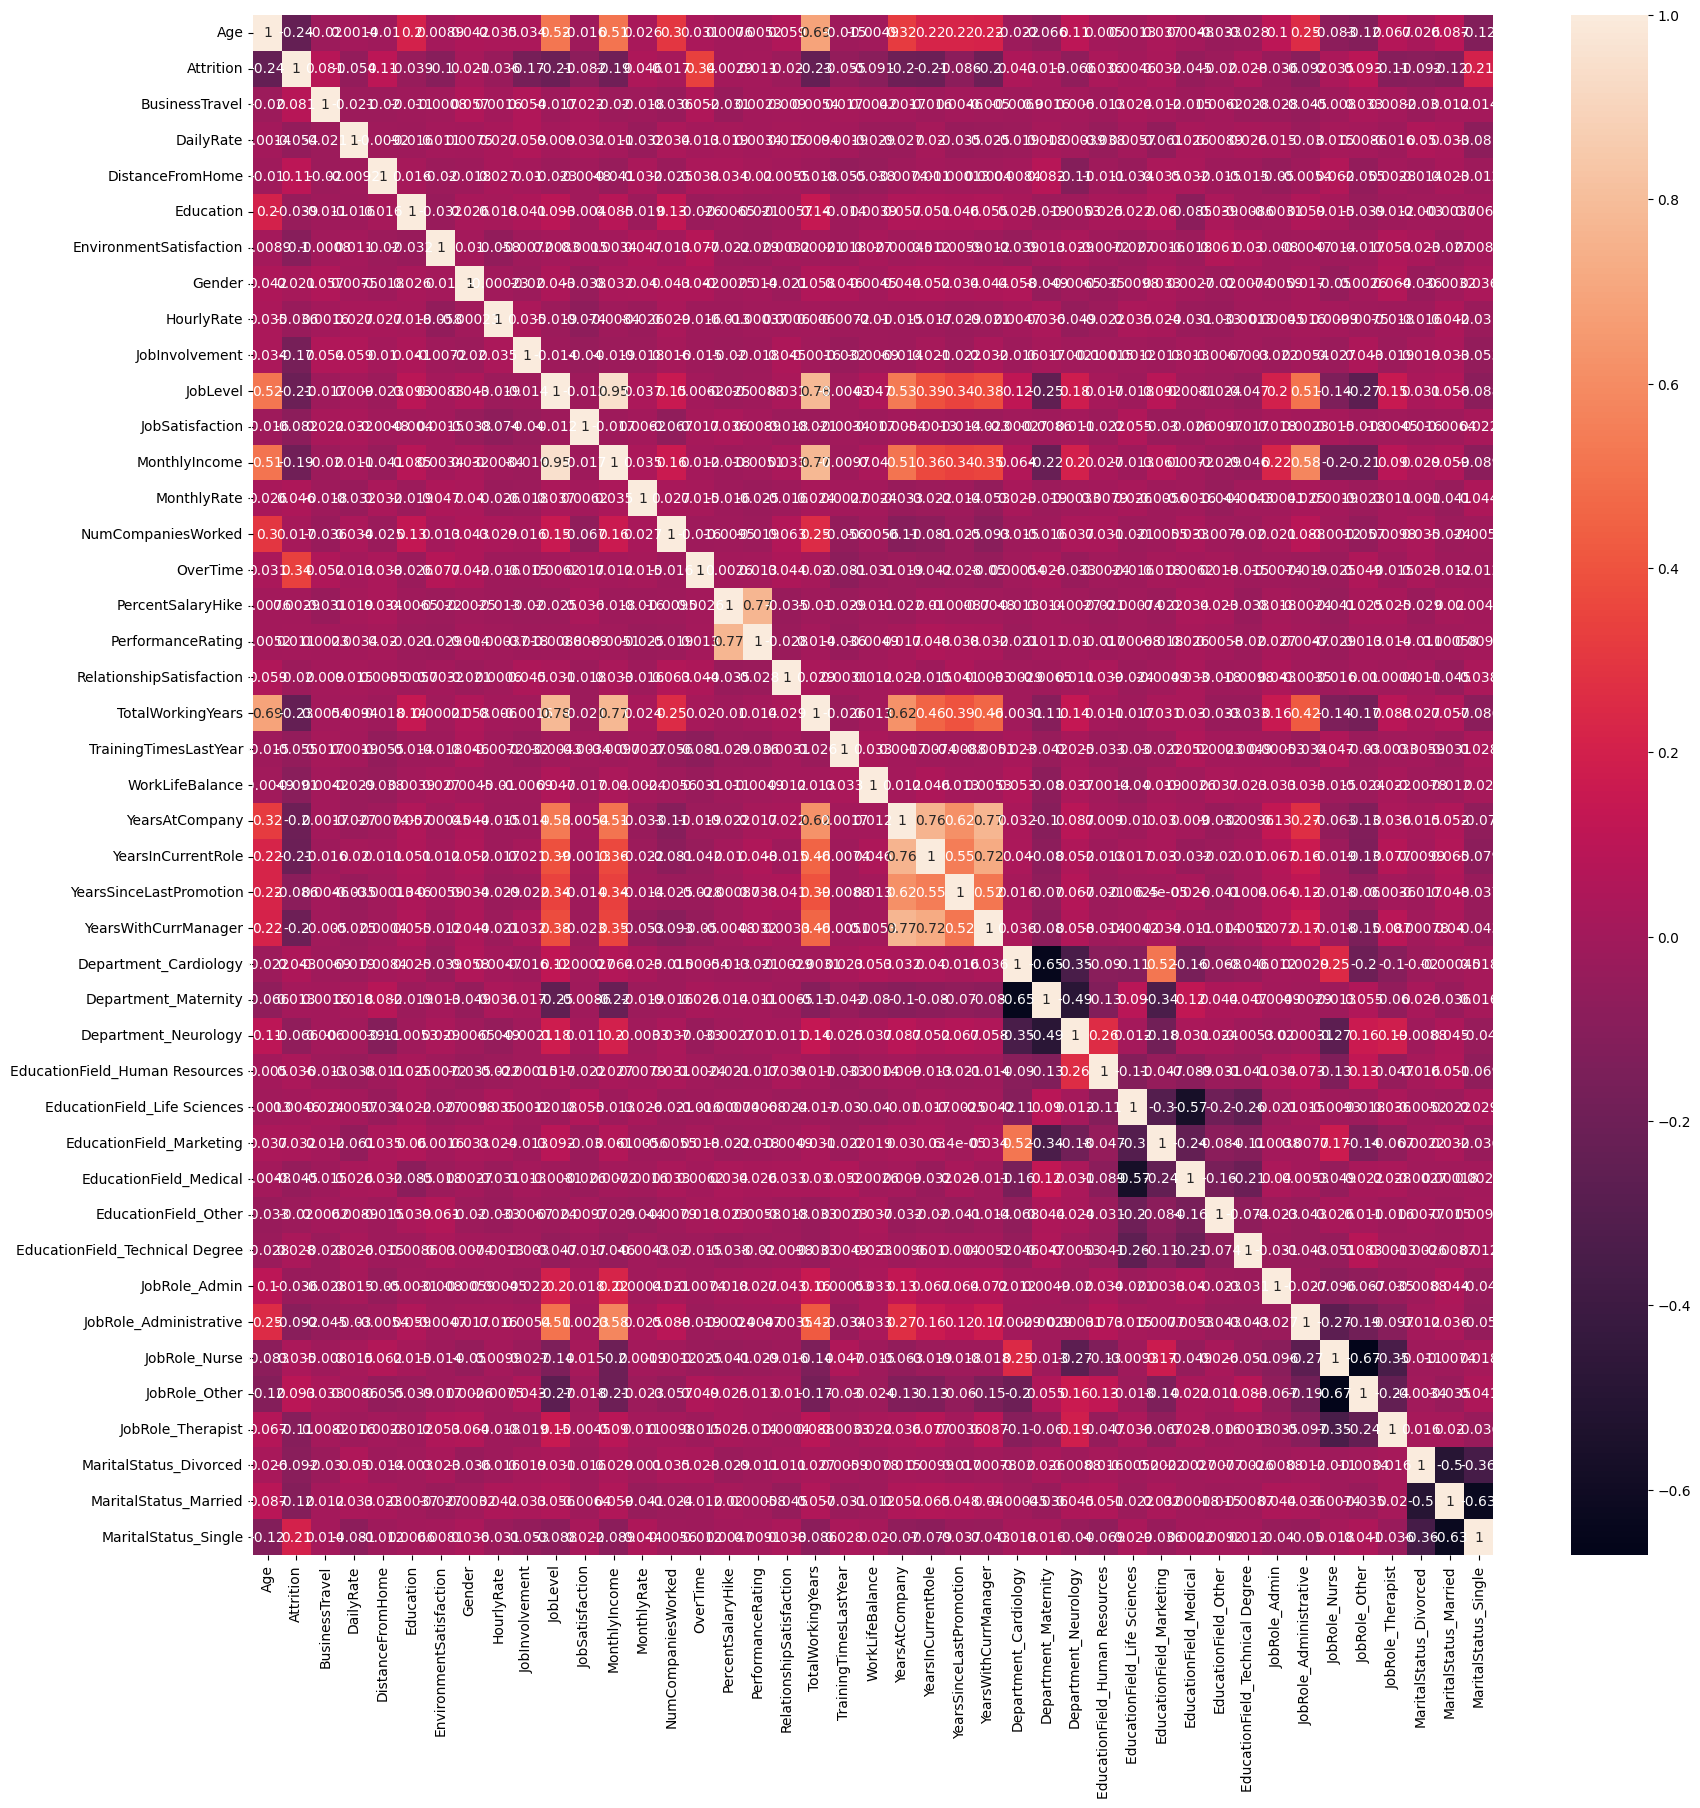

In [175]:
cor_total = train_df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(cor_total, annot=True)
plt.show()

In [182]:
# Check the most significant features
print('Positive Correlation')
print(cor['Attrition'].sort_values(ascending=False)[:10])

Positive Correlation
Attrition                   1.000000
DistanceFromHome            0.105580
MonthlyRate                 0.045744
NumCompaniesWorked          0.017279
PerformanceRating           0.010728
PercentSalaryHike           0.002943
RelationshipSatisfaction   -0.020462
HourlyRate                 -0.036300
Education                  -0.038843
DailyRate                  -0.053892
Name: Attrition, dtype: float64


In [181]:
print('Negative Correlation')
print(cor['Attrition'].sort_values(ascending=True)[:10])

Negative Correlation
Age                       -0.239984
TotalWorkingYears         -0.234182
YearsInCurrentRole        -0.207891
JobLevel                  -0.207634
YearsAtCompany            -0.201373
YearsWithCurrManager      -0.201087
MonthlyIncome             -0.193527
JobInvolvement            -0.166036
EnvironmentSatisfaction   -0.101278
WorkLifeBalance           -0.090513
Name: Attrition, dtype: float64


In [183]:
cor['Attrition']

Age                        -0.239984
Attrition                   1.000000
DailyRate                  -0.053892
DistanceFromHome            0.105580
Education                  -0.038843
EnvironmentSatisfaction    -0.101278
HourlyRate                 -0.036300
JobInvolvement             -0.166036
JobLevel                   -0.207634
JobSatisfaction            -0.081881
MonthlyIncome              -0.193527
MonthlyRate                 0.045744
NumCompaniesWorked          0.017279
PercentSalaryHike           0.002943
PerformanceRating           0.010728
RelationshipSatisfaction   -0.020462
TotalWorkingYears          -0.234182
TrainingTimesLastYear      -0.054836
WorkLifeBalance            -0.090513
YearsAtCompany             -0.201373
YearsInCurrentRole         -0.207891
YearsSinceLastPromotion    -0.086207
YearsWithCurrManager       -0.201087
Name: Attrition, dtype: float64